<a href="https://colab.research.google.com/github/mmw5yw/MadelineW/blob/master/Option_0_QC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project Madeline Williams**

mmw5yw

Final project for Quantified Cognition

**Option 0**: I chose this option because I have become comfortable with the data and code for this data set. I wanted to see if I could apply concepts from this class to the data to further analyze it with statistical models.

I used data set aa-2 from course Computational Neuroscience. This is not my own data, but was provided to me.

The researchers who obtained this data are **Sarah M.N. Wolley** and **Thane Fremouw**.


### **Introduction**

The researchers who gathered this data were interested in the neural computations associated with zebra finches as their neurons respond to different types of sound stimuli that range between natural and unnatural sounds.

The overarching goal of the project is to assess the finches’ optimization or preference for a certain song type by evaluating neuron spikes in their song control system.

The birds were tested for multiple anatomical brain regions:
- Nucleus Oviodalis (OV)
- Caudal Mesopallium (CM)
- Primary Forebrain (from subareas L1, L2a, L2b, L3 and L)
- Mesencephalicus lateral dorsalis (MLd)

Each bird is tested with stimuli from two or all three different classes of sounds.

The spiking response was recorded for the stimuli across multiple trials.

### **Classes of sounds**

The sounds used to stimulate the Zebra Finches ranged from least natural, medium, most natural.

These are listed below in order of most to least natural:
- Conspecific: natural birdsong from Zebra Finches
- Songrip: ripple stimuli with same modulation of song
- Flatrip: modulation limited noise with flat modulation spectrum

The Flatrip sound has the most white noise and is the most unnatural to the birds.

### **Hypothesis**

I may expect to see a higher number of spikes for the conspecific stimuli, or the most natural sound stimuli, showing the finches have an affinity for natural song over white noise. 

This would make sense, since evolutionarily and biologically speaking, finches communicate with natural song and do not necessarily ever hear white noise in the wild.

I would expect the finches neurological song system to be attuned to hearing natural song - to upkeep communication, nurturing, and learning in nature. 

### **Importing the Data**

- **First** import all the necessary accessories

In [319]:
# I wrote this notebook on a new Google Colab document so I could run these accessories
!pip install git+https://github.com/arviz-devs/arviz
!wget https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/dists.py


  Cloning https://github.com/arviz-devs/arviz to /tmp/pip-req-build-5e491dyl
  Running command git clone -q https://github.com/arviz-devs/arviz /tmp/pip-req-build-5e491dyl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for arviz: filename=arviz-0.7.0-cp36-none-any.whl size=2635798 sha256=2c4a25f571152664e7461b52531f53aae2becdbc7c80f3940b8cbb86f4c4c67d
  Stored in directory: /tmp/pip-ephem-wheel-cache-z_gm9kv9/wheels/93/b7/76/fe5931eb8154ca105ee91ddc249c6e1eaaa7b06988bdf8a400
Successfully built arviz
--2020-05-08 20:46:12--  https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/dists.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [text/

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import os
import matplotlib.pyplot as plt; plt.rcdefaults()
import pymc3 as pm
import dists
import requests
import io
import theano.tensor as T
import arviz as az
from sklearn import preprocessing
import seaborn as sns


- **Next** import the cell regions library of data.
- This is a csv. titled cell_regions_excel.

In [380]:
# I used a file finder for Colab that lets me choose the file I want to upload
# This allows whomever to download the required data sets and upload from their specific device,
# instead of hard coding for a direct path

from google.colab import files
uploaded = files.upload()

Saving cell_regions_excel.csv to cell_regions_excel (9).csv


In [0]:
# Here I have uploaded the cell regions into pandas so I can sort through the birds and the corresponding tested brain regions

cell_regions = pd.read_csv(io.BytesIO(uploaded['cell_regions_excel.csv']))

# Example of how to capture only the birds tested for brain region OV

cell_regions_OV = cell_regions[cell_regions['L1']=='OV']


- Now I have all the data in a pandas file of my choosing. 

- I chose brain region **Nucelus Oviodalis** because it seemed significant within the reading. 

- The paper associates a uniqueness with the OV brain region and the data set - given that there is importance in song learning for this region in finches. The researchers are unsure of its ability in determining preference between different types of song stimuli.

- The exact words in the research were "prevalent tuning to intermediate, spectral, and temporal modulations is unique to OV" 


- **Upload** the data from an excel file. 

- This upload contains each birds name, each spike trial for that bird, the brain region recorded from (OV), stimuli used, and count of spikes for each trial.
- This is a csv. titled Birds_region_stim_count

In [435]:
from google.colab import files
uploaded = files.upload()

Saving Birds_region_stim_count.csv to Birds_region_stim_count (8).csv


- I will want to focus on a specific bird for this brain region, and access the recorded spikes for each stimuli over trials.

In [584]:
from random import *

# I am choosing a random bird from the list - just for fun
# The length of the list of only OV birds is 59

# Bird pupi0414_2 does not have data for flatrip stimuli, so if its index is chosen we need to 'reshuffle'
y = randint(1,59)
if y != 6:
  x = y
else:
  print('Forbidden bird! Use this one instead:')

random_bird = cell_regions_OV.values[x]

# This is our randomized bird's name 
# It will be different each time so the data can stay fresh

random_bird[0]

'gr1070_3'

- Now, I will create a pandas dataframe for this specific bird from the file upload from earlier.

- This should include the chosen bird, corresponding brain region, stimuli, and the count of spikes for each trial.

- I have already put the data into an excel spreadsheet so it is accessible to pandas.

- Note: one of the birds, pupi0414_2, does not have data for the flatrip stimuli. If this bird is chosen from the random generator, the analysis will not work.

In [0]:
bird = pd.read_csv(io.BytesIO(uploaded['Birds_region_stim_count.csv']))

columns = ('Spike', 'Brain Region', 'Stimuli', 'Count')

- Now that the data is loaded into pandas, we can specify which bird and which stimulus we want to focus on.

In [586]:
# Specify the randomly chosen bird 

chosen_bird = bird[bird['Bird'] == random_bird[0]]

# Now specify the chosen stimulus, this will be done twice for the conspecifc and the flatrip

chosen_stim_con = chosen_bird[chosen_bird['Stimuli'] == 'conspecific']

chosen_stim_con

,Trial,Bird,Brain Region,Stimuli,Count
900,Spike 1,gr1070_3,OV,conspecific,491.0
901,Spike 2,gr1070_3,OV,conspecific,449.0
902,Spike 3,gr1070_3,OV,conspecific,445.0
903,Spike 4,gr1070_3,OV,conspecific,493.0
904,Spike 5,gr1070_3,OV,conspecific,408.0
905,Spike 6,gr1070_3,OV,conspecific,575.0
906,Spike 7,gr1070_3,OV,conspecific,600.0
907,Spike 8,gr1070_3,OV,conspecific,598.0
908,Spike 9,gr1070_3,OV,conspecific,511.0
909,Spike 10,gr1070_3,OV,conspecific,434.0


In [587]:
# Another for flatrip
# Specify the randomly chosen bird 

chosen_bird = bird[bird['Bird'] == random_bird[0]]

# Now specify the chosen stimulus, this will be done twice for the conspecifc and the flatrip

chosen_stim_flat = chosen_bird[chosen_bird['Stimuli'] == 'flatrip']

chosen_stim_flat

,Trial,Bird,Brain Region,Stimuli,Count
920,Spike 1,gr1070_3,OV,flatrip,546.0
921,Spike 2,gr1070_3,OV,flatrip,555.0
922,Spike 3,gr1070_3,OV,flatrip,504.0
923,Spike 4,gr1070_3,OV,flatrip,555.0
924,Spike 5,gr1070_3,OV,flatrip,572.0
925,Spike 6,gr1070_3,OV,flatrip,497.0
926,Spike 7,gr1070_3,OV,flatrip,498.0
927,Spike 8,gr1070_3,OV,flatrip,544.0
928,Spike 9,gr1070_3,OV,flatrip,566.0
929,Spike 10,gr1070_3,OV,flatrip,456.0


- Let me explain the data in the frame(s) above. 

- **First:** for the OV brain region, these birds were only tested for the conspecific and flatrip stimuli. They were not tested for and there is no data for songrip. So this is discarded.

- **Next:** for the conspecific stimuli the birds were tested over a course of 20 trials - resulting in 20 recordings of spikes over time. For flatrip they were only tested over 10 trials. 

- **Next:** the *count* column is the number of spikes recorded per trial for that stimulus. This only takes into account spikes recorded *after* the stimulus was presented to the birds (no negative time).

- In the code cell below, I show how I obtained these numbers for each trial.

In [0]:
# DON'T RUN CELL
# A list of how many spike trials were used for conspecific stimuli
spike_num_conspec = ['spike1', 'spike2', 'spike3', 'spike4', 'spike5', 'spike6', 'spike7', 'spike8', 
                     'spike9', 'spike10', 'spike11', 'spike12', 'spike13', 'spike14', 'spike15', 
                     'spike16', 'spike17', 'spike18', 'spike19', 'spike20']

# A list of how many spike trials were used for flatrip stimuli
spike_num_flatrip = ['spike1', 'spike2', 'spike3', 'spike4', 'spike5', 'spike6', 'spike7', 'spike8', 
                     'spike9', 'spike10']

# This works in my jupyter notebooks, but not in Colab, so I did all the computation and used the numbers for the excel spreadsheet
# Meaning this cell is not meant to be ran, it is just to show the code I used

# One for conspecific

addr = '/Users/madelinewilliams/Desktop/crcns 2/aa2/all_cells/gr0965_4/conspecific'   # The direct file path for my specific download
os.chdir(addr)
for stim in spike_num_conspec:
    #count the number of spikes with NO negatives
    positive_num = []
    neg = '-'
    stim_spike = open(stim,"r")
    contents = stim_spike.read()
    split = contents.split()
    arr = np.array(split)
    for x in arr:
        if neg not in x:
            positive_num.append(x)
    print(len(positive_num))    

# One for flatrip

addr = '/Users/madelinewilliams/Desktop/crcns 2/aa2/all_cells/gr0965_4/flatrip'
os.chdir(addr)
for stim in spike_num_flatrip:
    #count the number of spikes with NO negatives
    positive_num = []
    neg = '-'
    stim_spike = open(stim,"r")
    contents = stim_spike.read()
    split = contents.split()
    arr = np.array(split)
    for x in arr:
        if neg not in x:
            positive_num.append(x)
    print(len(positive_num))    

# This resulted in the amount of spikes per trial that were NOT negative numbers

### **Choosing a Model**

Since this data is finite numbers within finite 'bins' of birds with criteria and is not continuous, it is a probability mass function and not a probability density function.

For this reason a Poisson distribution should be used as a probability mass function.

Since there are multiple individuals/trials for this data set, we need a heirarchical model.

### **Poisson Distribution - Understanding the Application**

- A poisson distribution is a probability mass function that determines the probability of a number of events happening in a given time interval.
- The only parameter for Poisson distribution is **$\lambda$** - which is the **expected** number of occurances (mean spike count)
- The axes of the plot will include k and P, where k is the **actual** occurance (spikes counted for each trial) and P is the **probability** of k (probability the counted number of spikes for a trial is close to average)
- The data of counting spikes will benefit from a Poisson distribution as it will show, with a pmf, what the distribution of spike counts is for each bird (for each stimulus for a specific brain region, of course) compared to an expected value of occurance.

In [588]:
# Estimate and set a lambda for the randomized bird for each stimuli

average_1 = chosen_stim_con['Count'].mean()
average_2 = chosen_stim_flat['Count'].mean()

print('The average of conspecific counts for bird', random_bird[0], 'is', average_1)
print('The average of flatrip counts for bird', random_bird[0], 'is', average_2)

The average of conspecific counts for bird gr1070_3 is 492.6
The average of flatrip counts for bird gr1070_3 is 529.3


In [0]:
# Define a model to calculate the probability of count given the mean for each stimuli

def get_poisson_con(row):
  # parameters
  k = row['Count']
  mu = average_1

  # calculate the poisson probability for those parameters
  prob1 = poisson.pmf(k, mu)

  return prob1

chosen_stim_con['Probability'] = chosen_stim_con.apply(get_poisson, axis = 1)

# View the new dataframe including probability
# chosen_stim_con

In [590]:
def get_poisson_flat(row):
  # parameters
  k = row['Count']
  mu = average_2

  # calculate the poisson probability for those parameters
  prob2 = poisson.pmf(k, mu)

  return prob2

chosen_stim_flat['Probability'] = chosen_stim_flat.apply(get_poisson, axis = 1)

# View the new dataframe including probability
# chosen_stim_flat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
# Define the axes to graph the distribution
x_vals_flat = chosen_stim_flat['Count'].tolist()
y_vals_flat = chosen_stim_flat['Probability'].tolist()

x_vals_con = chosen_stim_con['Count'].tolist()
y_vals_con = chosen_stim_con['Probability'].tolist()

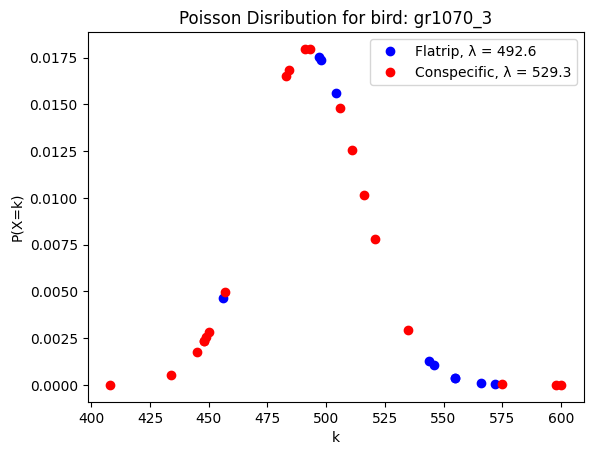

In [592]:
# Plot the distribution for conspecific and flatrip stimuli
label_flat = 'Flatrip, λ = ' + str(average_1)
label_con = 'Conspecific, λ = ' + str(average_2)

plt.plot(x_vals_flat, y_vals_flat, 'bo', label = label_flat)
plt.plot(x_vals_con, y_vals_con, 'ro', label = label_con)

plt.xlabel('k')
plt.ylabel('P(X=k)')
plt.title('Poisson Disribution for bird: ' + random_bird[0])
plt.legend()
plt.show()

- **Note:** the number of trials varies between 20 and 10 for conspecific vs. flatrip data. This is simply the data that the researchers provided, and they did not explain why fewer trials we used for flatrip stimuli.

### **Statistical Significance?**

Given that we now have a Poisson distribution of the two stimuli, are the numbers significantly different?

To do this I will use a Student's T-Test to determine if the average means are actually statistically different. 

In [593]:
A = chosen_stim_con['Count']
B = chosen_stim_flat['Count']

# I am using scipy's internal T Test function to compare the counts of conspecific and flatrip stimuli

a, b = stats.ttest_ind(A, B)
print("t-value = " + str(a))
print("p-value = " + str(b))

t-value = -1.9212539116012601
p-value = 0.06493356193997442


- The p-value and t-value resulting for each bird's counts will be different.
- The lower the p-value, the better. I have found for some birds the p-value is *very* lower (Ex: pupi0414_7: pvalue = 1.27e-09), while for others it is much higher (Ex:  blahp9904_8: pvalue = 0.8279)
- For many of the birds I have individually run (not the total 58 birds), I have received a p-value > 0.05. This means there is a higher likelihood that the differences in data occured by chance.
- The resulting t-values show a ratio of how different the two stimuli groups are from *each other* vs. different within themselves.


### **Summary of Findings**

Ultimately, the goal is to determine if there is a significant difference in probability of spiking for the different sounds.

This would indicate that finches' may have an affinity for one sound over the other.

My plan of action was to use a Poisson distribution pmf model to plot the probability of spiking per trial with the.

Each time all these cells are run, a new bird will be chosen randomly and the plot will reflect its own unique distribution. Similarly, each time a new bird is chose a T-Test is conducted to gather statistical evidence between the two stimuli.

The **$\lambda$** value, which represents the expected number of spikes counted, was calculated from mean number of spikes for a specific stimulus across trials. This is the best fitting parameter because it is the ideal number of spikes recorded for each trial and correspondingly plots the actual spike counts around it. This way we can visualize the probability differences in average spike count for each stimuli.

Given that the T-Tests for each run of the dataframes produced inconsistent p-values ranging from low liklihood of chance to very high and small t-values, there is ultimately *no* significant difference in the data. My hypothesis is therefore denied.



**Final thoughts**

It *is* still interesting to note that for many of the birds, flatrip stimuli produced a higher number of spikes (on average) across trials. *If* this difference was statistically significant, it would still deny my hypothesis. 

I would theorize that this could be possible due to habituation of natural song for the finches. Meaning the finches are used to hearing natural song, which habituates neuronal firing, and when white noise/unnatural sound is heard, reactivates neurons causing "surprise". 

Yet since the difference is not significant and pretty variable, this may not be the case either.


### **Citations**

**Data:**

Theunissen, Frederic E.; Gill, Patrick; Noopur, Amin; Zhang, Junli; Woolley, Sarah M. N.; Fremouw, Thane (2011): Single-unit recordings from multiple auditory areas in male zebra finches. 

CRCNS.org.
http://dx.doi.org/10.6080/10.6080/K0JW8BSC

Sarah Woolley (sw2277@columbia.edu

Thane Fremouw (thane_fremouw@umit.maine.edu)

**Code and Information:**

Sederberg, Per, Quantified Cognition, (2020), GitHub repository, https://github.com/compmem/QuantCog 

Including:
- 05 Bayesian Regression
- 06 Bayesian Data Analysis

T-Test information help:
https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

Poisson distribution information help:
https://en.wikipedia.org/wiki/Poisson_distribution#Parameter_estimation




P.s. Thank you for your support and understanding throughout this process :)